# Predictive Maintenance Analysis for Machine Failure Prevention

This analysis aims at developing a predictive maintenance solution to identify and prevent machine failures before they occur. By leveraging sensor data and machine parameters, we aim to build a model that can accurately predict potential failures, enabling proactive maintenance, reducing downtime, and optimizing operational efficiency.

## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

## Load the Dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/ai4i2020.csv')
df

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,M24855,M,298.8,308.4,1604,29.5,14,0,0,0,0,0,0
9996,9997,H39410,H,298.9,308.4,1632,31.8,17,0,0,0,0,0,0
9997,9998,M24857,M,299.0,308.6,1645,33.4,22,0,0,0,0,0,0
9998,9999,H39412,H,299.0,308.7,1408,48.5,25,0,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

## Correlation Matrix

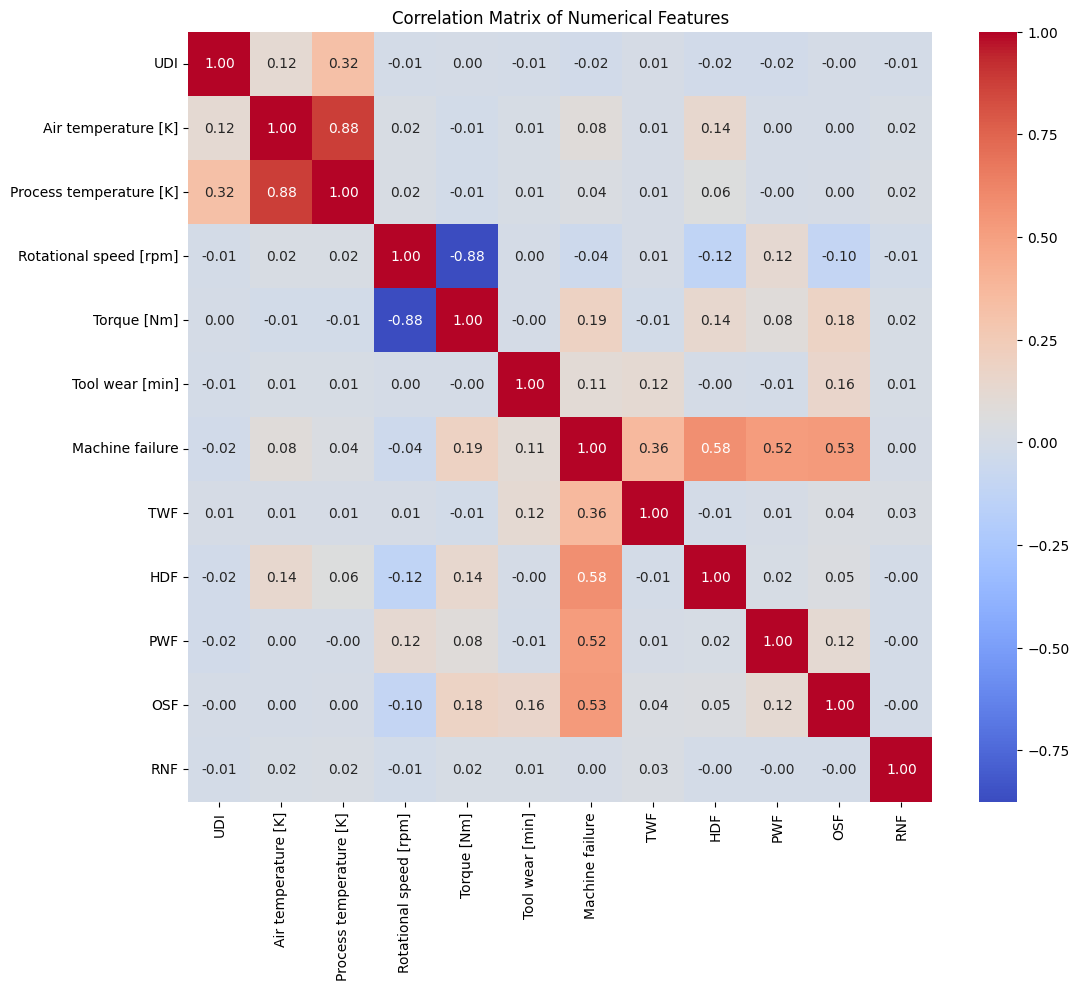

In [ ]:
# Select only numerical columns for correlation matrix
numerical_df = df.select_dtypes(include=np.number)

# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

## Understand the Target Variable


In [ ]:
failure_counts = df['Machine failure'].value_counts()
print("Value counts of 'Machine failure':")
print(failure_counts)

failure_percentages = df['Machine failure'].value_counts(normalize=True) * 100
print("\nPercentage of 'Machine failure' classes:")
print(failure_percentages)

Value counts of 'Machine failure':
Machine failure
0    9661
1     339
Name: count, dtype: int64

Percentage of 'Machine failure' classes:
Machine failure
0    96.61
1     3.39
Name: proportion, dtype: float64


## Feature Engineering




In [ ]:
df['temp_interaction'] = df['Air temperature [K]'] * df['Process temperature [K]']
df['power'] = df['Rotational speed [rpm]'] * df['Torque [Nm]']
df['tool_wear_sq'] = df['Tool wear [min]']**2
df['temp_difference'] = df['Process temperature [K]'] - df['Air temperature [K]']

display(df.head())

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF,temp_interaction,power,tool_wear_sq,temp_difference
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0,91993.66,66382.8,0,10.5
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0,92054.34,65190.4,9,10.5
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0,91963.85,74001.2,25,10.4
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0,92024.52,56603.5,49,10.4
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0,92054.34,56320.0,81,10.5


## Data Preprocessing


In [ ]:
# Identify categorical column
categorical_column = 'Type'

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=[categorical_column], drop_first=True)

# Separate features (X) and target (y)
X = df_encoded.drop('Machine failure', axis=1)
y = df_encoded['Machine failure']

# Identify numerical columns (excluding UDI, Product ID, and the target variable)
numerical_columns = X.select_dtypes(include=np.number).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in ['UDI', 'Product ID']]


# Scale numerical features
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Display the first few rows of the preprocessed feature set
display(X.head())

,UDI,Product ID,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],TWF,HDF,PWF,OSF,RNF,temp_interaction,power,tool_wear_sq,temp_difference,Type_L,Type_M
0,1,M14860,-0.952389,-0.947360,0.068185,0.282200,-1.695984,-0.06798,-0.10786,-0.097934,-0.099484,-0.04363,-0.980109,0.629443,-1.095358,0.498849,False,True
1,2,L47181,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,-0.06798,-0.10786,-0.097934,-0.099484,-0.04363,-0.921349,0.512456,-1.094730,0.498849,True,False
2,3,L47182,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,-0.06798,-0.10786,-0.097934,-0.099484,-0.04363,-1.008976,1.376889,-1.093614,0.398954,True,False
3,4,L47183,-0.902393,-0.947360,-0.590021,-0.048845,-1.586009,-0.06798,-0.10786,-0.097934,-0.099484,-0.04363,-0.950226,-0.330009,-1.091940,0.398954,True,False
4,5,L47184,-0.902393,-0.879959,-0.729472,0.001313,-1.554588,-0.06798,-0.10786,-0.097934,-0.099484,-0.04363,-0.921349,-0.357824,-1.089708,0.498849,True,False


## Model Training

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate Logistic Regression model
logistic_model = LogisticRegression(class_weight='balanced', random_state=42)

# Instantiate Random Forest Classifier model
rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)

# Drop 'UDI' and 'Product ID' columns from the feature sets
X_train = X_train.drop(['UDI', 'Product ID'], axis=1)
X_test = X_test.drop(['UDI', 'Product ID'], axis=1)

# Train Logistic Regression model
logistic_model.fit(X_train, y_train)

# Train Random Forest Classifier model
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

## Model Evaluation


In [ ]:
# Evaluate Logistic Regression model
y_pred_lr = logistic_model.predict(X_test)
y_prob_lr = logistic_model.predict_proba(X_test)[:, 1]

print("Logistic Regression Model Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

print("\nAUC-ROC Score:")
print(roc_auc_score(y_test, y_prob_lr))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Logistic Regression Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       1.00      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000


AUC-ROC Score:
0.977781347491947

Confusion Matrix:
[[1939    0]
 [   2   59]]


In [ ]:
# Evaluate Random Forest Classifier model
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

print("\nRandom Forest Classifier Model Evaluation:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

print("\nAUC-ROC Score:")
print(roc_auc_score(y_test, y_prob_rf))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))


Random Forest Classifier Model Evaluation:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1939
           1       1.00      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000


AUC-ROC Score:
0.9817888213461392

Confusion Matrix:
[[1939    0]
 [   2   59]]


## Model Interpretation


In [ ]:
# Access feature importances
feature_importances = rf_model.feature_importances_

# Create a pandas Series with feature names as index
feature_importance_series = pd.Series(feature_importances, index=X_train.columns)

# Sort feature importances in descending order
sorted_feature_importances = feature_importance_series.sort_values(ascending=False)

# Display the sorted feature importances
print("Sorted Feature Importances:")
display(sorted_feature_importances)

Sorted Feature Importances:


,0
Rotational speed [rpm],0.152339
Torque [Nm],0.132992
power,0.120931
PWF,0.112695
HDF,0.102413
TWF,0.091359
Tool wear [min],0.073641
OSF,0.066761
tool_wear_sq,0.061154
temp_difference,0.039321


## Summary:

### Data Analysis Key Findings

*   The target variable 'Machine failure' is highly imbalanced, with approximately 96.61% non-failure instances and only 3.39% failure instances.
*   Several new features were engineered, including `temp_interaction`, `power`, `tool_wear_sq`, and `temp_difference`, which could potentially improve the predictive model.
*   Categorical features were successfully handled using one-hot encoding, and numerical features were scaled to ensure similar ranges.
*   Both Logistic Regression and Random Forest models were trained and evaluated for predicting machine failure.
*   Both models showed strong performance on the test set, with high precision, recall, and F1-scores for both classes, and AUC-ROC scores of approximately 0.978 for Logistic Regression and 0.982 for Random Forest.
*   The most important features for predicting machine failure according to the Random Forest model are 'Rotational speed \[rpm]', 'Torque \[Nm]', and the engineered 'power' feature, followed by 'PWF', 'HDF', and 'TWF'.

### Insights or Next Steps

*   Given the strong performance of both models on the imbalanced dataset, further analysis could focus on deploying the slightly better-performing Random Forest model for real-time predictive maintenance.
*   Investigating the relationships between the top important features (Rotational speed, Torque, and Power) and machine failure could provide actionable insights for preventing failures.


## Non-Technical Summary

This project aimed to predict when machines might break down so we can fix them *before* they actually fail. We used data from machine sensors and settings to build a "smart" system that can spot the early signs of trouble.

Here's what we found:

* **Some machines break down more often than others.** We noticed that only a small percentage of machines in our data actually failed (about 3.4%). This means our system needs to be good at finding those rare cases.
* **We created new ways to look at the data.** We combined some of the machine's readings, like temperature and speed, to see if these combinations could give us better clues about potential failures.
* **We built two prediction models.** We used two different methods to predict failures. Both worked really well.
* **The models were very accurate.** Both models were great at correctly identifying both machines that would fail and those that wouldn't.
* **We found the most important signals for failure.** Our best model told us that the machine's spinning speed, how much force it's using (torque), and the combined "power" from these two are the strongest indicators of a potential breakdown. Other important signals include different types of manufacturing defects (PWF, HDF, TWF).

**What this means:**

Because our prediction system works so well, we can use the better of the two models to help predict failures in real-time. By keeping an eye on the key signals we identified (speed, torque, power, and defect types), we can perform maintenance proactively and avoid costly downtime.

# Interactive Machine Failure Prediction Dashboard

## Install gradio


In [ ]:
!pip install gradio

## Load the Trained Model and Scaler

In [ ]:
# Access the trained Random Forest model
trained_model = rf_model

# Access the fitted StandardScaler
fitted_scaler = scaler

print("Trained Random Forest Model:", trained_model)
print("Fitted StandardScaler:", fitted_scaler)

Trained Random Forest Model: RandomForestClassifier(class_weight='balanced', random_state=42)
Fitted StandardScaler: StandardScaler()


## Define the Prediction Function


In [ ]:
import gradio as gr

# Main prediction function
def predict_failure_with_display(
    air_temp, process_temp, rotational_speed, torque, tool_wear,
    twf, hdf, pwf, osf, rnf, type_l, type_m
):
    # Convert boolean checkboxes to integers
    twf_int = 1 if twf else 0
    hdf_int = 1 if hdf else 0
    pwf_int = 1 if pwf else 0
    osf_int = 1 if osf else 0
    rnf_int = 1 if rnf else 0

    # Create a DataFrame from input parameters
    input_data = pd.DataFrame([[
        air_temp, process_temp, rotational_speed, torque, tool_wear,
        twf_int, hdf_int, pwf_int, osf_int, rnf_int, type_l, type_m,
        air_temp * process_temp,
        rotational_speed * torque,
        tool_wear**2,
        process_temp - air_temp
    ]], columns=[
        'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
        'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
        'Type_L', 'Type_M', 'temp_interaction', 'power', 'tool_wear_sq',
        'temp_difference'
    ])

    correct_column_order = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
                           'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
                           'temp_interaction', 'power', 'tool_wear_sq', 'temp_difference',
                           'Type_L', 'Type_M']
    input_data = input_data[correct_column_order]

    numerical_cols_input = [col for col in input_data.columns if col not in ['Type_L', 'Type_M']]
    input_data[numerical_cols_input] = fitted_scaler.transform(input_data[numerical_cols_input])

    prediction_probability = trained_model.predict_proba(input_data)[:, 1]

    # Create a formatted output with risk level
    prob = float(prediction_probability[0])
    safe_prob = float(1 - prob)

    # Determine risk category and create formatted output
    if prob < 0.3:
        risk_emoji = "🟢"
        risk_level = "LOW RISK"
        risk_color = "#10b981"
    elif prob < 0.7:
        risk_emoji = "🟡"
        risk_level = "MEDIUM RISK"
        risk_color = "#f59e0b"
    else:
        risk_emoji = "🔴"
        risk_level = "HIGH RISK"
        risk_color = "#ef4444"

    # Create HTML output for better control
    html_output = f"""
    <div style="text-align: center; padding: 20px;">
        <div style="font-size: 48px; margin-bottom: 10px;">{risk_emoji}</div>
        <div style="font-size: 32px; font-weight: bold; color: {risk_color}; margin-bottom: 20px;">
            {risk_level}
        </div>
        <div style="background: #1f2937; border-radius: 10px; padding: 20px; margin-top: 20px;">
            <div style="display: flex; justify-content: space-between; margin-bottom: 15px;">
                <span style="font-size: 18px;">⚠️ Failure Probability:</span>
                <span style="font-size: 24px; font-weight: bold; color: {risk_color};">{prob:.1%}</span>
            </div>
            <div style="display: flex; justify-content: space-between;">
                <span style="font-size: 18px;">✅ Safe Probability:</span>
                <span style="font-size: 24px; font-weight: bold; color: #10b981;">{safe_prob:.1%}</span>
            </div>
        </div>
    </div>
    """

    return html_output

## Build the Gradio Interface


In [ ]:
# Custom CSS for better styling
custom_css = """
.gradio-container {
    font-family: 'Arial', sans-serif;
}
"""

# Create the interface with tabs for better organization
with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as iface:

    gr.Markdown(
        """
        # 🏭 Machine Failure Prediction Dashboard
        ### Predictive Maintenance Analytics System
        Enter machine parameters below to assess failure probability and risk level.
        """
    )

    with gr.Row():
        with gr.Column(scale=2):
            gr.Markdown("### 📊 Machine Parameters")

            with gr.Tab("Environmental Conditions"):
                with gr.Row():
                    air_temp = gr.Slider(
                        minimum=290, maximum=310, value=300, step=0.1,
                        label="🌡️ Air Temperature (K)",
                        info="Ambient temperature around the machine"
                    )
                    process_temp = gr.Slider(
                        minimum=300, maximum=320, value=310, step=0.1,
                        label="🔥 Process Temperature (K)",
                        info="Operating temperature during process"
                    )

            with gr.Tab("Operational Parameters"):
                with gr.Row():
                    rotational_speed = gr.Slider(
                        minimum=1000, maximum=3000, value=1500, step=10,
                        label="⚙️ Rotational Speed (rpm)",
                        info="Machine rotation speed"
                    )
                    torque = gr.Slider(
                        minimum=0, maximum=100, value=40, step=0.5,
                        label="🔧 Torque (Nm)",
                        info="Applied torque force"
                    )

                tool_wear = gr.Slider(
                    minimum=0, maximum=300, value=100, step=1,
                    label="⏱️ Tool Wear (min)",
                    info="Cumulative tool usage time"
                )

            with gr.Tab("Machine Type"):
                gr.Markdown("**Select Machine Type** (Type_H is default when both are 0)")
                with gr.Row():
                    type_l = gr.Radio(
                        choices=[0, 1], value=0,
                        label="Type L - Low Quality",
                        info="Select 1 for Type L machine"
                    )
                    type_m = gr.Radio(
                        choices=[0, 1], value=0,
                        label="Type M - Medium Quality",
                        info="Select 1 for Type M machine"
                    )

            with gr.Tab("Failure Indicators"):
                gr.Markdown("**Known Failure Modes** (Check if failure detected)")
                with gr.Row():
                    with gr.Column():
                        twf = gr.Checkbox(label="🔨 Tool Wear Failure (TWF)", value=False)
                        hdf = gr.Checkbox(label="🌡️ Heat Dissipation Failure (HDF)", value=False)
                        pwf = gr.Checkbox(label="⚡ Power Failure (PWF)", value=False)
                    with gr.Column():
                        osf = gr.Checkbox(label="💪 Overstrain Failure (OSF)", value=False)
                        rnf = gr.Checkbox(label="🎲 Random Failure (RNF)", value=False)

        with gr.Column(scale=1):
            gr.Markdown("### 🎯 Prediction Results")

            predict_btn = gr.Button(
                "🔍 Analyze Failure Risk",
                variant="primary",
                size="lg"
            )

            output = gr.HTML(
                label="Risk Assessment"
            )

            gr.Markdown(
                """
                ---
                ### 📈 Risk Levels Guide
                - 🟢 **LOW RISK** (<30%): Normal operation
                - 🟡 **MEDIUM RISK** (30-70%): Monitor closely
                - 🔴 **HIGH RISK** (>70%): Immediate attention required

                ### 💡 Recommendations
                - Schedule maintenance during medium/high risk
                - Monitor tool wear regularly
                - Maintain optimal temperature ranges
                """
            )

    predict_btn.click(
        fn=predict_failure_with_display,
        inputs=[
            air_temp, process_temp, rotational_speed, torque, tool_wear,
            twf, hdf, pwf, osf, rnf, type_l, type_m
        ],
        outputs=output
    )

    gr.Markdown(
        """
        ---
        <center>
        <small>⚙️ Powered by Machine Learning | Last Updated: 2025</small>
        </center>
        """
    )

In [ ]:
# Launch the interface
iface.launch(share=False, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Note: opening Chrome Inspector may crash demo inside Colab notebooks.
* To create a public link, set `share=True` in `launch()`.


<IPython.core.display.Javascript object>

Keyboard interruption in main thread... closing server.


## Exporting Predictions for Power BI

In [ ]:
# Add this cell to your existing Colab notebook after all your analysis is complete
# This will generate predictions for your entire dataset and export to Power BI

import pandas as pd
import numpy as np

print("="*60)
print("EXPORTING PREDICTIONS FOR POWER BI")
print("="*60)

# Step 1: Load the original dataset again (before any transformations)
df_original = pd.read_csv('/content/drive/MyDrive/datasets/ai4i2020.csv')
print(f"\n✅ Dataset loaded: {len(df_original)} rows")

# Step 2: Create a copy for predictions
df_pred = df_original.copy()

# Step 3: Apply the same feature engineering you did in your analysis
df_pred['temp_interaction'] = df_pred['Air temperature [K]'] * df_pred['Process temperature [K]']
df_pred['power'] = df_pred['Rotational speed [rpm]'] * df_pred['Torque [Nm]']
df_pred['tool_wear_sq'] = df_pred['Tool wear [min]']**2
df_pred['temp_difference'] = df_pred['Process temperature [K]'] - df_pred['Air temperature [K]']

# Step 4: Apply one-hot encoding for Type column
df_pred_encoded = pd.get_dummies(df_pred, columns=['Type'], drop_first=True)

# Step 5: Prepare features in the correct order (same as your training)
feature_columns = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]',
                   'Torque [Nm]', 'Tool wear [min]', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF',
                   'temp_interaction', 'power', 'tool_wear_sq', 'temp_difference',
                   'Type_L', 'Type_M']

X_pred = df_pred_encoded[feature_columns]

# Step 6: Scale the numerical features (using your fitted scaler)
numerical_columns = [col for col in feature_columns if col not in ['Type_L', 'Type_M']]
X_pred[numerical_columns] = fitted_scaler.transform(X_pred[numerical_columns])

# Step 7: Generate predictions using your trained Random Forest model
print("\n⏳ Generating predictions...")
predictions_prob = trained_model.predict_proba(X_pred)[:, 1]
predictions_class = trained_model.predict(X_pred)

# Step 8: Add predictions back to original dataframe
df_pred_original = df_original.copy()
df_pred_original['Predicted_Failure'] = predictions_class
df_pred_original['Failure_Probability'] = predictions_prob
df_pred_original['Failure_Probability_Percent'] = (predictions_prob * 100).round(2)

# Step 9: Add Risk Level classification
def classify_risk(prob):
    if prob < 0.3:
        return 'LOW'
    elif prob < 0.7:
        return 'MEDIUM'
    else:
        return 'HIGH'

df_pred_original['Risk_Level'] = df_pred_original['Failure_Probability'].apply(classify_risk)

# Step 10: Add risk colors for Power BI
risk_colors = {
    'LOW': '#10b981',      # Green
    'MEDIUM': '#f59e0b',   # Orange
    'HIGH': '#ef4444'      # Red
}
df_pred_original['Risk_Color'] = df_pred_original['Risk_Level'].map(risk_colors)

# Step 11: Add helpful derived columns for Power BI
df_pred_original['Temperature_Difference'] = df_pred_original['Process temperature [K]'] - df_pred_original['Air temperature [K]']
df_pred_original['Power'] = df_pred_original['Rotational speed [rpm]'] * df_pred_original['Torque [Nm]']
df_pred_original['Needs_Attention'] = df_pred_original['Risk_Level'].apply(lambda x: 'Yes' if x in ['MEDIUM', 'HIGH'] else 'No')
df_pred_original['Risk_Score'] = df_pred_original['Failure_Probability_Percent']

# Step 12: Add actual failure outcome comparison
df_pred_original['Actual_Failure'] = df_original['Machine failure']
df_pred_original['Prediction_Correct'] = (df_pred_original['Predicted_Failure'] == df_pred_original['Actual_Failure'])

# Step 13: Display summary statistics
print("\n" + "="*60)
print("PREDICTION SUMMARY")
print("="*60)
print(f"\nTotal Machines Analyzed: {len(df_pred_original)}")
print(f"\nRisk Level Distribution:")
print(df_pred_original['Risk_Level'].value_counts())
print(f"\nRisk Level Percentages:")
print(df_pred_original['Risk_Level'].value_counts(normalize=True).mul(100).round(2))
print(f"\nAverage Failure Probability: {df_pred_original['Failure_Probability'].mean():.2%}")
print(f"\nMachines Needing Attention (MEDIUM/HIGH): {len(df_pred_original[df_pred_original['Needs_Attention'] == 'Yes'])}")
print(f"\nPrediction Accuracy: {df_pred_original['Prediction_Correct'].mean():.2%}")

# Step 14: Show top 10 highest risk machines
print("\n" + "="*60)
print("TOP 10 HIGHEST RISK MACHINES")
print("="*60)
top_risk = df_pred_original.nlargest(10, 'Failure_Probability')[
    ['UDI', 'Product ID', 'Type', 'Risk_Level', 'Failure_Probability_Percent',
     'Tool wear [min]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Actual_Failure']
]
print(top_risk.to_string())

# Step 15: Show prediction performance breakdown
print("\n" + "="*60)
print("PREDICTION PERFORMANCE BY RISK LEVEL")
print("="*60)
for risk in ['LOW', 'MEDIUM', 'HIGH']:
    subset = df_pred_original[df_pred_original['Risk_Level'] == risk]
    actual_failures = subset['Actual_Failure'].sum()
    total = len(subset)
    print(f"\n{risk} RISK:")
    print(f"  Total Machines: {total}")
    print(f"  Actual Failures: {actual_failures}")
    print(f"  Failure Rate: {(actual_failures/total*100):.2f}%")

# Step 16: Export to Excel (Primary format for Power BI)
output_file_excel = '/content/drive/MyDrive/machine_predictions_for_powerbi.xlsx'
df_pred_original.to_excel(output_file_excel, index=False, sheet_name='Predictions')
print(f"\n✅ Excel file saved: {output_file_excel}")

# Step 17: Also export to CSV (Backup option)
output_file_csv = '/content/drive/MyDrive/machine_predictions_for_powerbi.csv'
df_pred_original.to_csv(output_file_csv, index=False)
print(f"✅ CSV file saved: {output_file_csv}")

# Step 18: Display columns available for Power BI
print("\n" + "="*60)
print("COLUMNS AVAILABLE FOR POWER BI VISUALIZATION")
print("="*60)
for i, col in enumerate(df_pred_original.columns, 1):
    print(f"{i:2}. {col}")

print("\n" + "="*60)
print("✅ FILES READY FOR POWER BI IMPORT!")
print("="*60)
print("\n📊 Next Steps:")
print("1. Download the Excel file from your Google Drive")
print("2. Open Power BI Desktop")
print("3. Get Data → Excel → Select the downloaded file")
print("4. Follow the Power BI tutorial to create visualizations")

# Step 19: Create a summary DataFrame for quick insights
summary_stats = pd.DataFrame({
    'Metric': [
        'Total Machines',
        'Low Risk Count',
        'Medium Risk Count',
        'High Risk Count',
        'Avg Failure Probability',
        'Machines Needing Attention',
        'Prediction Accuracy'
    ],
    'Value': [
        len(df_pred_original),
        len(df_pred_original[df_pred_original['Risk_Level'] == 'LOW']),
        len(df_pred_original[df_pred_original['Risk_Level'] == 'MEDIUM']),
        len(df_pred_original[df_pred_original['Risk_Level'] == 'HIGH']),
        f"{df_pred_original['Failure_Probability'].mean():.2%}",
        len(df_pred_original[df_pred_original['Needs_Attention'] == 'Yes']),
        f"{df_pred_original['Prediction_Correct'].mean():.2%}"
    ]
})

print("\n" + "="*60)
print("QUICK SUMMARY FOR STAKEHOLDERS")
print("="*60)
print(summary_stats.to_string(index=False))

# Display first few rows of the export
print("\n" + "="*60)
print("PREVIEW OF EXPORTED DATA (First 5 rows)")
print("="*60)
display(df_pred_original.head())

print("\n🎉 Export complete! Ready for Power BI analysis.")

EXPORTING PREDICTIONS FOR POWER BI

✅ Dataset loaded: 10000 rows


/tmp/ipython-input-3781817737.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_pred[numerical_columns] = fitted_scaler.transform(X_pred[numerical_columns])



⏳ Generating predictions...

PREDICTION SUMMARY

Total Machines Analyzed: 10000

Risk Level Distribution:
Risk_Level
LOW       9663
HIGH       328
MEDIUM       9
Name: count, dtype: int64

Risk Level Percentages:
Risk_Level
LOW       96.63
HIGH       3.28
MEDIUM     0.09
Name: proportion, dtype: float64

Average Failure Probability: 3.31%

Machines Needing Attention (MEDIUM/HIGH): 337

Prediction Accuracy: 99.98%

TOP 10 HIGHEST RISK MACHINES
       UDI Product ID Type Risk_Level  Failure_Probability_Percent  Tool wear [min]  Rotational speed [rpm]  Torque [Nm]  Actual_Failure
50      51     L47230    L       HIGH                        100.0              143                    2861          4.6               1
194    195     M15054    M       HIGH                        100.0               86                    2678         10.7               1
1335  1336     L48515    L       HIGH                        100.0              228                    1371         53.8               1
1391

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,...,Failure_Probability,Failure_Probability_Percent,Risk_Level,Risk_Color,Temperature_Difference,Power,Needs_Attention,Risk_Score,Actual_Failure,Prediction_Correct
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,...,0.0,0.0,LOW,#10b981,10.5,66382.8,No,0.0,0,True
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,...,0.0,0.0,LOW,#10b981,10.5,65190.4,No,0.0,0,True
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,...,0.0,0.0,LOW,#10b981,10.4,74001.2,No,0.0,0,True
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,...,0.0,0.0,LOW,#10b981,10.4,56603.5,No,0.0,0,True
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,...,0.0,0.0,LOW,#10b981,10.5,56320.0,No,0.0,0,True



🎉 Export complete! Ready for Power BI analysis.
